### Full Name :Ali bakhtiari
### Student Number : 400104794
___

# Problem
In this project our goal is to develop a framework for simple neural network and multi layer perceptron. We are going to use only `numpy` and no other packages to build our own classes and network.

# Setup

In [21]:
###################################
#  Do Not Add any other packages  #
###################################

import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import tqdm
import copy
from abc import ABC, abstractmethod
from sklearn.metrics import  ConfusionMatrixDisplay
import seaborn
from sklearn.datasets import fetch_openml # just for downloading the dataset (MNIST)

plt.style.use('ggplot')

# Section 1: Modules implementation (65 Points)
We are going to implement the required modules for a neural network. Each of these modules must implement the necessary functions, `_forward` and `backward`. In the following parts, we will implement the `LinearLayer`, `ReLU`, `batchnorm`, `dropout`, and `SoftMax` layers.

## Layers

In [22]:
###################################
#     Do Not change this cell     #
###################################

class Module(ABC):
    def __call__(self, *args):
        return self._forward(*args)

    @abstractmethod
    def _forward(self, *args):
        pass

def rel_error(x, y):
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

#### Linear Layer (5 Points)

The `LinearLayer` class represents a linear (fully connected) layer in a neural network. This layer computes the linear transformation of the input data as Wx + b, where W is the weight matrix, x is the input data, and b is the bias vector.

In [23]:
class LinearLayer(Module):
    """
    A linear layer module that calculates (Wx + b).
    """

    def __init__(self, dim_in, dim_out, initializer, reg, alpha):
        """
        Args:
            - dim_in: input dimension,
            - dim_out: output dimension,
            - initializer: a function that takes (dim_in, dim_out) and initialize a [dim_in x dim_out] matrix,
            - reg: L2-regularization flag
            - alpha: L2-regularization coefficient
        """
        self.dim_in = dim_in
        self.dim_out = dim_out
        self.params = {
            'W': initializer(dim_in, dim_out),
            'b': np.zeros(dim_out),
            'reg': alpha if reg else 0,
        }
        self.grads = dict()
        self.cache = dict()

    def _forward(self, x, mode='train'):
        """
        linear forward function, calculates Wx+b for a batch of data

        Args:
            x : a batch of data
            mode: the step of training which can be train, valid and test

        Note:
            you need to store some values in cache to be able to
            calculate backward path.
        """
        #####################################################
        ##        Forward function for linear layer        ##
        ####################[Your Code]###################### 
        out = x.dot(self.params["W"]) + self.params["b"]
        self.cache["x"] = x

        return out

    def backward(self, upstream):
        """
        gets upstream gradient and returns downstream gradient

        Args:
            upstream : upstream gradient of loss w.r.t module output

        Note:
            you need to calculate gradient of loss w.r.t module input
            and parameters and store them in grads (don't return anything).
        """
        #####################################################
        ##        Backward function for linear layer       ##
        ####################[Your Code]######################
        W = self.params["W"]
        x = self.cache["x"]
        self.grads["x"] = upstream.dot(W.T )
        self.grads["W"] = x.T @ upstream
        self.grads["reg"] = 2 * self.params['reg'] * W
        self.grads["b"] = upstream.sum()

In [24]:
###################################
#     Do not change this cell     #
#   output must be from o(e-5)    #
###################################

def check_gradient_linear(linear, h=0.00001):
    np.random.seed(121212)
    x = np.random.normal(size=(20, linear.dim_in))
    upstream = np.random.random(size=(20, linear.dim_out))

    new_x = x + h
    new_w = linear.params['W'] + h
    new_b = linear.params['b'] + h
    new_linear = copy.deepcopy(linear)
    new_linear.params['W'] = new_w
    new_linear.params['b'] = new_b
    new_val = new_linear(new_x)
    old_val = linear(x)
    delta_output = new_val - old_val
    delta_loss_indirect = np.sum(delta_output * upstream)

    linear.backward(upstream)
    delta_loss_direct = np.sum(h * linear.grads['x'])
    delta_loss_direct += np.sum(h * linear.grads['W'])
    delta_loss_direct += np.sum(h * linear.grads['b'])

    print(f'Relative error of delta-loss (for linear unit):\n{rel_error(delta_loss_indirect, delta_loss_direct)}')

    old_val = np.sum(np.power(linear.params['W'], 2))
    new_val = np.sum(np.power(new_w, 2))
    indirect_loss = new_val - old_val
    direct_loss = np.sum(h * linear.grads['reg'])
    print(f'Relative error of delta-loss (for regularization):\n{rel_error(indirect_loss, direct_loss)}')

def initializer(x, y): return np.random.normal(size=(x, y))

linear = LinearLayer(5, 10, initializer, reg=True, alpha=1)
check_gradient_linear(linear, h=0.00001)

Relative error of delta-loss (for linear unit):
1.690052244668115e-05
Relative error of delta-loss (for regularization):
2.156059301890756e-05


#### ReLU Layer (5 Points)

The `ReLU` class represents a Rectified Linear Unit (ReLU) activation function, which is commonly used in neural networks to introduce non-linearity. This method applies the ReLU activation function to the input data x. The ReLU function is defined as ReLU(x) = max(0, x) meaning that it outputs the input directly if it is positive, otherwise it outputs zero.

In [25]:
import numpy as np

class ReLU(Module):
    """
    Rectified Linear Unit function
    """

    def __init__(self):
        self.cache = dict()
        self.grads = dict()

    def _forward(self, x, mode='train'):
        """
        Applies ReLU function on x.

        Args:
            x : a batch of data
            mode: the step of training which can be train, valid and test

        Returns:
            y : ReLU of input
        """
        # Apply ReLU activation
        y = np.maximum(0, x)

        # Store input for use in backward pass if training
        if mode == 'train':
            self.cache['x'] = x

        return y

    def backward(self, upstream):
        """
        Calculate and store gradient of loss w.r.t module input.

        Args:
            upstream : gradient of loss w.r.t model output

        Note:
            You need to calculate gradient of loss w.r.t module input
            and parameters and store them in grads (don't return anything).
        """
        x = self.cache['x']
        # Calculate gradient of ReLU
        dx = np.array(upstream, copy=True)  # Copy upstream gradient
        dx[x <= 0] = 0  # Zero gradient where input was non-positive

        # Store the gradient of the input in grads
        self.grads['x'] = dx

        # Normally no need to return anything, but let's return dx for possible external use
        return dx


In [26]:
###################################
#     Do not change this cell     #
#   output must be from o(e-8)    #
###################################

def check_gradient_relu(rl, h=0.0001):
    np.random.seed(11111)
    x = np.random.normal(size=(10, 5))
    upstream = np.random.random(size=(10, 5))

    new_x = x + h
    new_val = rl(new_x)
    old_val = rl(x)
    delta_output = new_val - old_val
    delta_loss_indirect = np.sum(delta_output * upstream)

    rl.backward(upstream)
    delta_loss_direct = np.sum(h * rl.grads['x'])

    print(f'Relative error of delta-loss:\n{rel_error(delta_loss_indirect, delta_loss_direct)}')

relu = ReLU()
check_gradient_relu(relu)

Relative error of delta-loss:
2.484727903125079e-14


#### SoftMax Layer (10 Points)

We could have a layer that calculates softmax for us. In other word, for input $x\in\mathcal{R}^N$ it would return $y\in\mathcal{R}^n$ where $y_i = \frac{e^{x_i}}{\sum e^{x_i}}$. But this method is not numerical stable because $e^{x_i}$ in this formulation can get very large easly and return `nan`. Instead of that we will implement a logarithmic version of softmax which instead of calculating $\frac{e^{x_i}}{\sum e^{x_i}}$, will calculate $\log\left(\frac{e^{x_i}}{\sum e^{x_i}}\right) = x_i - \log\sum e^{x_i}$. In order to calculate second term you can use `np.logaddexp` but this function only works on two inputs. For more than two inputs, fill in the following function to be able to calculate log sum exp of an array of shape (b,n). `axis=1` means sum over columns and `axis=0` sum over rows.

In [27]:
import numpy as np

def logsumexp(array, axis=1):
    """
    Calculate log(sum(exp(array))) using np.logaddexp to prevent numerical issues.

    Args:
        array : input array
        axis : reduce axis, 1 means columns and 0 means rows
    """

    # Use np.max to find the maximum value in the array along the specified axis
    # This is used to stabilize the computation
    max_val = np.max(array, axis=axis, keepdims=True)

    # Subtract the max value to stabilize the computation against large exponentials
    stabilized_array = array - max_val

    # First compute sum(exp(array)) in a numerically stable way
    sum_exp = np.exp(stabilized_array)
    sum_exp = np.sum(sum_exp, axis=axis)

    # Take the log of the sum of exponentials and then add the max value back
    result = np.log(sum_exp) + np.squeeze(max_val, axis=axis)

    max_val = np.max(array, axis=axis, keepdims=True)
    ans= max_val + np.log(np.sum(np.exp(array - max_val), axis=axis, keepdims=True))
    return ans



In [28]:

class LogSoftMax(Module):
    def __init__(self):
        self.cache = dict()
        self.grads = dict()

    def _forward(self, x, mode='train'):
        """
        Calculate log softmax of x.

        Args:
            x : batch of data with shape (b,m)
            mode: the step of training which can be train, valid and test

        Returns:
            y : log softmax of x with shape (b,m)
        """
        # Using log-sum-exp trick for numerical stability
        max_x = np.max(x, axis=1, keepdims=True)
        stabilized_x = x - max_x
        sum_exp = np.sum(np.exp(stabilized_x), axis=1, keepdims=True)
        log_sum_exp = np.log(sum_exp)
        log_softmax = stabilized_x - log_sum_exp

        if mode == 'train':
            self.cache['x'] = x
            self.cache['log_softmax'] = log_softmax

        return log_softmax

    def backward(self, upstream):
        """
        Calculate and store the gradient of loss w.r.t module input.

        Args:
            upstream : gradient of loss w.r.t module output with shape (b,m)
        """
        x = self.cache['x']
        log_softmax = self.cache['log_softmax']
        softmax = np.exp(log_softmax)

        # Gradient of the log softmax
        dx = softmax * (upstream - np.sum(upstream * softmax, axis=1, keepdims=True))

        self.grads['x'] = dx

        return dx



In [29]:
###################################
#     Do not change this cell     #
#   output must be from o(e-7)    #
###################################

def check_gradient_softmax(sm, h=0.0001):
    np.random.seed(321321)
    x = np.random.random(size=(10, 5))
    upstream = np.random.random(size=(10, 5))

    new_x = x + h
    new_val = sm(new_x)
    old_val = sm(x)
    delta_output = new_val - old_val
    delta_loss_indirect = np.sum(delta_output * upstream)

    sm.backward(upstream)
    delta_loss_direct = np.sum(h * sm.grads['x'])

    print(f'Relative error of delta-loss:\n{rel_error(delta_loss_indirect, delta_loss_direct)}')

sm = LogSoftMax()
check_gradient_softmax(sm)

Relative error of delta-loss:
1.3446648037662018e-12


#### BatchNorm Layer (10 Points)

The `BatchNorm` class represents a batch normalization layer, which normalizes the inputs of each mini-batch to have zero mean and unit variance, and then scales and shifts them using learned parameters.
<br>
In `train` mode, this method:
<br>
Computes the mean and variance of the current batch. Normalizes the input batch using the batch statistics. Scales and shifts the normalized batch using the `gamma` and `beta` parameters. Updates the running mean and variance using the computed batch statistics.
<br>
In `valid` or `test` mode, this method:
<br>
Normalizes the input batch using the running mean and variance. Scales and shifts the normalized batch using the `gamma` and `beta` parameters.

In [30]:
class BatchNorm(Module):
    def __init__(self, dim_in, momentum=0.99, eps=1e-3):
        """
        Batch normalization layer for neural networks.

        Args:
            dim_in: Input dimension.
            momentum: Momentum for moving average of mean and variance.
            eps: Small constant to prevent division by zero.
        """
        self.cache = dict()
        self.grads = dict()
        self.momentum = momentum
        self.eps = eps
        self.dim_in = dim_in
        self.params = {
            'gamma': np.ones(dim_in),
            'beta': np.zeros(dim_in),
            'running_mean': np.zeros(dim_in),
            'running_var': np.zeros(dim_in),
        }

    def _forward(self, x, mode='train'):
        """
        gets x and calculates batchnorm of that.

        Args:
            x : batch of data with shape (b,m)
            mode: the step of training which can be train, valid and test

        Returns:
            y : log batchnorm of x with shape (b,m)
        """
        #####################################################
        ##      Forward function for Batchnorm layer       ##
        ####################[Your Code]######################
        
        if mode == 'train':
            batch_mean = np.mean(x, axis=0)
            batch_var = np.var(x, axis=0)
            
            self.params['running_mean'] = self.momentum * self.params['running_mean'] + (1 - self.momentum) * batch_mean
            self.params['running_var'] = self.momentum * self.params['running_var'] + (1 - self.momentum) * batch_var
            
            x_normalized = (x - batch_mean) / np.sqrt(batch_var + self.eps)
            
            out = self.params['gamma'] * x_normalized + self.params['beta']
            
            self.cache['x'] = x
            self.cache['x_normalized'] = x_normalized
            self.cache['batch_mean'] = batch_mean
            self.cache['batch_var'] = batch_var
        else:
            x_normalized = (x - self.params['running_mean']) / np.sqrt(self.params['running_var'] + self.eps)
            out = self.params['gamma'] * x_normalized + self.params['beta']
        
        return out

    def backward(self, upstream):
        """
        calculates gradient of loss w.r.t module input and save that in grads.

        Args:
            upstream : gradient of loss w.r.t module output with shape (b,m)

        Note:
            you need to calculate gradient of loss w.r.t module input
            and parameters and store them in grads (don't return anything).
        """
        #####################################################
        ##      Backward function for Batchnorm layer      ##
        ####################[Your Code]######################
        

        x = self.cache['x']
        N, D = x.shape

        x_normalized = self.cache['x_normalized']
        batch_mean = self.cache['batch_mean']
        batch_var = self.cache['batch_var']
        gamma = self.params['gamma']
        beta = self.params['beta']
        
        self.grads['beta'] = np.sum(upstream, axis=0)
        self.grads['gamma'] = np.sum(upstream * x_normalized, axis=0)
        
        dx_normalized = upstream * gamma
        dvar = np.sum(dx_normalized * (x - batch_mean) * -0.5 * (batch_var + self.eps) ** -1.5, axis=0)
        dmean = np.sum(dx_normalized * -1 / np.sqrt(batch_var + self.eps), axis=0) + dvar * np.mean(-2 * (x - batch_mean), axis=0)
        
        self.grads['x'] = dx_normalized / np.sqrt(batch_var + self.eps) + dvar * 2 * (x - batch_mean) / N + dmean / N

#### Dropout Layer (5 Points)

The `Dropout` class represents a dropout layer, which randomly sets a fraction of input units to zero during training to prevent overfitting.
<br>
In `train` mode, this method:
<br>
Randomly sets a fraction of input units to zero with probability `prob`.
<br>
In `valid` or `test` mode, this method:
<br>
Returns the input data unchanged.

In [31]:
class Dropout(Module):
    def __init__(self, prob=0.5):
        """
        Dropout layer for neural networks.

        Args:
            prob: Probability of dropping out a neuron.
        """
        self.cache = dict()
        self.grads = dict()
        self.prob = prob

    def _forward(self, x, mode='train'):
        """
        gets x and calculates dropout of that.

        Args:
            x : batch of data with shape (b,m)
            mode: the step of training which can be train, valid and test

        Returns:
            y : dropout of x with shape (b,m)
        """
        #####################################################
        ##       Forward function for Dropout layer        ##
        ####################[Your Code]######################

        if mode == 'train':
            mask = (np.random.rand(*x.shape) >= self.prob) / (1.0 - self.prob)
            self.cache['mask'] = mask
            out = x * mask
        else:
            out = x
        
        return out

    def backward(self, upstream):
        """
        calculates gradient of loss w.r.t module input and save that in grads.

        Args:
            upstream : gradient of loss w.r.t module output with shape (b,m)

        Note:
            you need to calculate gradient of loss w.r.t module input
            and parameters and store them in grads (don't return anything).
        """
        #####################################################
        ##       Backward function for Dropout layer       ##
        ####################[Your Code]######################

        mask = self.cache['mask']
        dx = upstream * mask
        self.grads['x'] = dx

## Model (5 Points)
We need a model class which gathers our layers togather and performs forward and backward on all of them.

In [32]:
class MLPModel(Module):
    """
    A multilayer neural network model
    """

    def __init__(self, layers):
        """
        Args:
            layers : list of model layers
        """
        self.layers = layers

    def _forward(self, x, mode='train'):
        """
        Performs forward on x

        Args:
            x : a batch of data
            mode: the step of training which can be train, valid and test

        Returns:
            o : model output
        """
        #####################################################
        ##                  Forward on x                   ##
        ####################[Your Code]######################
        
        for layer in self.layers:
            x = layer._forward(x, mode)
        return x

    def backward(self, upstream):
        """
        Perform backward path on whole model

        Args:
            upstream : gradient of loss w.r.t model output
        """
        #####################################################
        ##                  Backward on x                  ##
        ####################[Your Code]######################

        for layer in reversed(self.layers):
            layer.backward(upstream)
            upstream = layer.grads["x"]

    def get_parameters(self):
        """
        Returns:
            parametric_layers : all layers of model which have parameter (you need it for optimizer input)
        """
        #####################################################
        ##         Find parameters of all layers           ##
        ####################[Your Code]######################

        parametric_layers = []
        
        for layer in self.layers:
            if hasattr(layer, 'params'):
                parametric_layers.append(layer)
        return parametric_layers      

## Loss functions (10 Points)
We need to implement loss functions to be able to train our network. We will implement CrossEntropy loss function. But notice that we have implemented `LogSoftMax` in logarithmic way so input of the following class will be logarithm of probabilities.
<br>
The `CrossEntropyLoss` class represents the cross-entropy loss function, which is commonly used in classification tasks to measure the difference between predicted probabilities and true labels. This method calculates the cross-entropy loss between the predicted probabilities (converted to log probabilities) and the true labels. The cross-entropy loss is computed using the formula: $ -\frac{1}{b} \sum_{i=1}^{b} \log(p_{i, \text{target}_i}) $, where the value inside the parentheses is the predicted probability of the correct class for the ith sample.

In [33]:


class CrossEntropyLoss(Module):
    def __init__(self):
        self.cache = dict()
        self.grads = dict()

    def _forward(self, logprobs, targets):
        batch_size = logprobs.shape[0]
        # Convert log probabilities to probabilities
        probs = np.exp(logprobs)
        # Compute the negative log likelihood loss
        target_logprobs = logprobs[np.arange(batch_size), targets]
        loss = -np.mean(target_logprobs)
        # Store for backpropagation
        self.cache['logprobs'] = logprobs
        self.cache['targets'] = targets
        self.cache['batch_size'] = batch_size
        return loss

    def backward(self, upstream):
        logprobs = self.cache['logprobs']
        targets = self.cache['targets']
        batch_size = self.cache['batch_size']

        # Initialize gradients with respect to log probabilities
        dL_dlogprobs = np.zeros_like(logprobs)
        dL_dlogprobs[np.arange(batch_size), targets] -= 1 / batch_size
        # Multiply by upstream gradient
        dL_dlogprobs *= upstream

        self.grads['x'] = dL_dlogprobs

    def __call__(self, logprobs, targets):
        return self._forward(logprobs, targets)



In [34]:
###################################
#     Do not change this cell     #
#   output must be from o(e-10)   #
###################################

def check_gradient_ce(ce, h=0.0001):
    np.random.seed(123123)
    target = np.random.randint(5, size=10)
    probs = np.random.random(size=(10, 5))
    upstream = 1

    new_probs = probs + h
    new_val = ce(new_probs, target)
    old_val = ce(probs, target)
    delta_output = new_val - old_val
    delta_loss_indirect = np.sum(delta_output * upstream)

    ce.backward(upstream)
    delta_loss_direct = np.sum(h * ce.grads['x'])

    print(f'Relative error of delta-loss:\n{rel_error(delta_loss_indirect, delta_loss_direct)}')

ce = CrossEntropyLoss()
check_gradient_ce(ce, h=0.0001)

Relative error of delta-loss:
3.327145416815998e-13


## Optimization (15 Points)

Now that we have our network and loss function, we need to update model paremeters. We can do so by using `Optimizer` class that perform updating rule on model parameters. You need to implement `sgd`, `adam` and `momentum` strategy for this optimizers. Becareful to consider regularization update for linear units that require regularization.
<br>
SGD:
<br>
$$
\theta = \theta - \eta \cdot \nabla_{\theta}J(\theta)
$$
<br>
Momentum:
<br>
$$
\begin{aligned}
v &= \mu \cdot v - \eta \cdot \nabla_{\theta}J(\theta) \\
\theta &= \theta + v
\end{aligned}
$$
<br>
Adam:
<br>
\begin{align*}
m_t &= \beta_1 \cdot m_{t-1} + (1 - \beta_1) \cdot \nabla_{\theta}J(\theta) \\
v_t &= \beta_2 \cdot v_{t-1} + (1 - \beta_2) \cdot (\nabla_{\theta}J(\theta))^2 \\
\hat{m}_t &= \frac{m_t}{1 - \beta_1^t} \\
\hat{v}_t &= \frac{v_t}{1 - \beta_2^t} \\
\theta &= \theta - \eta \cdot \frac{\hat{m}_t}{\sqrt{\hat{v}_t} + \epsilon}
\end{align*}

In [35]:
class Optimizer():
    """
    Our main optimization class.

    You can add arguments to _sgd and _momentum function if you need to do so, and
    pass this arguments to step function when using optimizer. Don't change __init__
    or step function.
    """

    def __init__(self, layers, strategy, lr):
        """
        Initialize the optimizer.

        Args:
            layers: Model layers (those whose parameters we want to update).
            strategy: Optimization strategy ('sgd', 'momentum', or 'adam').
            lr (callable): Learning rate function that takes the epoch as input.
        """
        self.layers = layers
        self.strategy = strategy
        self.lr = lr
        self.strategies = {
            'sgd': self._sgd,
            'momentum': self._momentum,
            'adam': self._adam,
        }
        self.momentum_changes = dict([])

    def step(self, *args):
        """
        Perform the specified update strategy on all layer parameters.

        Args:
            *args: Additional arguments specific to the chosen strategy.
        """
        self.strategies[self.strategy](*args)

    def _sgd(self, epoch):
        """
        Perform stochastic gradient descent update on layer parameters.

        Args:
            epoch: Current training epoch.
        """
        #####################################################
        ##         SGD optimizer implementation            ##
        ####################[Your Code]######################
        
        lr = self.lr(epoch)
        
        for layer in self.layers:
            if hasattr(layer, 'params'):
                for param_name, param_value in layer.params.items():
                    if param_name in layer.grads.keys() and param_name != 'reg':
                        gradient = layer.grads[param_name]

                        if param_name == 'W' and 'reg' in layer.grads.keys():
                            gradient += layer.grads['reg']

                        layer.params[param_name] -= lr * gradient

    def _momentum(self, epoch, momentum=0.9):
        """
        Perform momentum update on layer parameters.

        Args:
            epoch: Current training epoch.
            momentum: Momentum coefficient.
        """
        #####################################################
        ##       Momentum optimizer implementation         ##
        ####################[Your Code]######################
        
        lr = self.lr(epoch)

        for layer in self.layers:
            if hasattr(layer, 'params'):
                for param_name, param_value in layer.params.items():
                    if param_name in layer.grads.keys() and param_name != 'reg':
                        gradient = layer.grads[param_name]

                        if param_name == 'W' and 'reg' in layer.grads.keys():
                            gradient += layer.grads['reg']

                        if (layer, param_name) not in self.momentum_changes:
                            self.momentum_changes[(layer, param_name)] = np.zeros_like(gradient)

                        velocity = self.__momentum_change(momentum, (layer, param_name), gradient, epoch)
                        layer.params[param_name] += velocity

    def __momentum_change(self, momentum, key, value, epoch):
        """
        Update momentum for a specific parameter.

        Args:
            momentum: Current momentum coefficient.
            key: Tuple representing the parameter index and type.
            value: Gradient value for the parameter.

        Returns:
            float: Updated momentum value.
        """
        #####################################################
        ##   Momentum optimizer for a specific parameter   ##
        ####################[Your Code]######################
        
        lr = self.lr(epoch)
        
        layer, param_name = key
        
        self.momentum_changes[(layer, param_name)] = momentum * self.momentum_changes[(layer, param_name)] - lr * value
        return self.momentum_changes[(layer, param_name)]

    def _adam(self, epoch, beta1=0.9, beta2=0.999, eps=1e-8):
        """
        Perform Adam update on layer parameters.

        Args:
            epoch: Current training epoch.
            beta1: Exponential decay rate for first moment estimates.
            beta2: Exponential decay rate for second moment estimates.
            eps: Small constant to prevent division by zero.
        """
        #####################################################
        ##         Adam optimizer implementation           ##
        ####################[Your Code]######################
        
        lr = self.lr(epoch)

        for layer in self.layers:
            if hasattr(layer, 'params'):
                for param_name, param_value in layer.params.items():
                    if param_name in layer.grads.keys() and param_name != 'reg':
                        gradient = layer.grads[param_name]

                        if param_name == 'W' and 'reg' in layer.grads.keys():
                            gradient += layer.grads['reg']

                        if (layer, param_name) not in self.momentum_changes:
                            self.momentum_changes[(layer, param_name, 'm')] = np.zeros_like(gradient)
                            self.momentum_changes[(layer, param_name, 'v')] = np.zeros_like(gradient)

                        velocity = self.__adam_change(epoch, beta1, beta2, eps, (layer, param_name), gradient)
                        layer.params[param_name] -= lr * velocity

    def __adam_change(self, epoch, beta1, beta2, eps, key, value):
        """
        Update Adam parameters for a specific parameter.

        Args:
            epoch: Current training epoch.
            beta1: Exponential decay rate for first moment estimates.
            beta2: Exponential decay rate for second moment estimates.
            eps: Small constant to prevent division by zero.
            key: Tuple representing the parameter index and type.
            value: Gradient value for the parameter.

        Returns:
            float: Updated parameter value.
        """
        #####################################################
        ##     Adam optimizer for a specific parameter     ##
        ####################[Your Code]######################

        layer, param_name = key

        m = self.momentum_changes[(layer, param_name, 'm')]
        v = self.momentum_changes[(layer, param_name, 'v')]

        m = beta1 * m + (1 - beta1) * value
        v = beta2 * v + (1 - beta2) * (value ** 2)

        m_hat = m / (1 - beta1 ** (epoch + 1))
        v_hat = v / (1 - beta2 ** (epoch + 1))

        update = m_hat / (np.sqrt(v_hat) + eps)
        
        self.momentum_changes[(layer, param_name, 'm')] = m
        self.momentum_changes[(layer, param_name, 'v')] = v

        return update

# Section 2: MNIST Classification (35 Points)

Now that we can build a neural network we want to solve MNIST classification problem. This dataset consists of 70000 $28 \times 28$ grayscale images in 10 classes.

## Data preparation (5 Points)

In [36]:
#######################################################################
##  Download MNIST dataset and split it to train and test (1 point)  ##
##############################[Your Code]##############################
import keras
print(keras.__version__)
from keras.datasets import mnist
(train_X, train_y), (test_X, test_y) = mnist.load_data()

3.4.1


In [37]:
##############################################
##  Split train set to train/val (1 point)  ##
################[Your Code]###################


##############################################
# Print shapes to verify
print('X_train: ' + str(train_X.shape))
print('Y_train: ' + str(train_y.shape))
print('X_test:  '  + str(test_X.shape))
print('Y_test:  '  + str(test_y.shape))


X_train: (60000, 28, 28)
Y_train: (60000,)
X_test:  (10000, 28, 28)
Y_test:  (10000,)


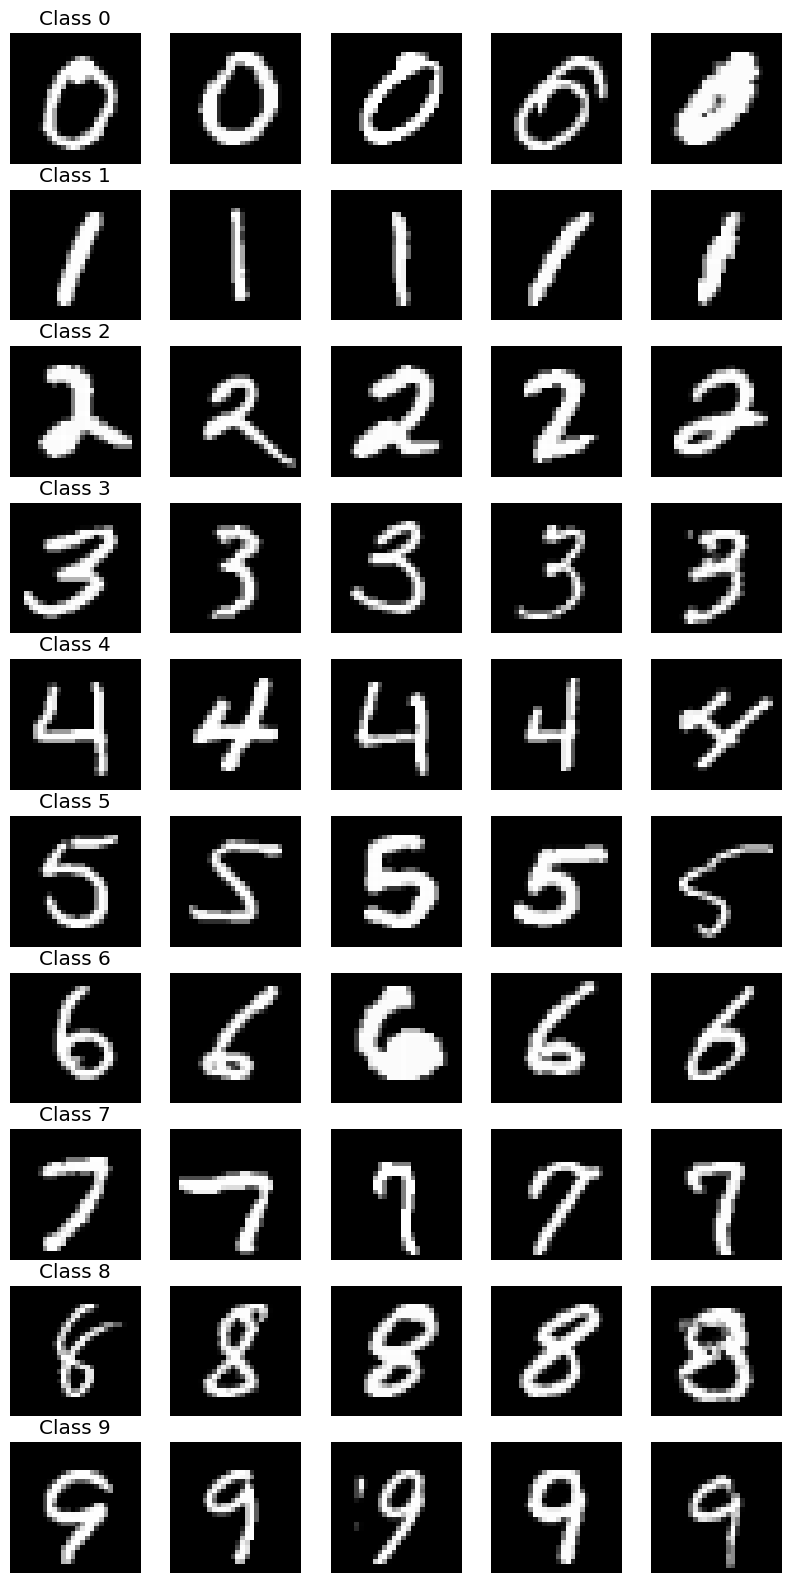

In [38]:
###################################################
## Visualize 5 samples from each class (1 point) ##
##################[Your Code]######################
# print(train_y)
# print(train_X)

# Function to plot samples for each class
def plot_samples_per_class(images, labels, num_classes=10, num_samples=5):
    fig, axes = plt.subplots(num_classes, num_samples, figsize=(num_samples * 2, num_classes * 2))
    for i in range(num_classes):
        # Find indices of labels equal to the current class i
        idxs = np.flatnonzero(labels == i)
        idxs = np.random.choice(idxs, num_samples, replace=False)
        for j in range(num_samples):
            ax = axes[i, j]
            ax.imshow(images[idxs[j]], cmap='gray', interpolation='none')
            ax.axis('off')
            if j == 0:
                ax.set_title(f'Class {i}')
    plt.show()

# Plotting 5 samples from each class
plot_samples_per_class(train_X, train_y)



Now normalize the data (mean=0 and std=1) and also flattern the input because we have just linear layers and we need two have a vector as input.

In [39]:
#####################################################
##        Normalize and flatten X (2 points)       ##
####################[Your Code]######################
import numpy as np
from sklearn.model_selection import train_test_split


# Normalize the data
def normalize_data(images):
    # Flatten the images: change from (num_samples, 28, 28) to (num_samples, 784)
    flattened_images = images.reshape(images.shape[0], -1)
    
    # Calculate the mean and std along the pixel values
    mean = np.mean(flattened_images, axis=0)
    std = np.std(flattened_images, axis=0)
    
    # Avoid division by zero
    std[std == 0] = 1
    
    # Normalize images
    normalized_images = (flattened_images - mean) / std
    return normalized_images

# Applying normalization to training and testing datasets
train_X = normalize_data(train_X)
test_X = normalize_data(test_X)

train_X, val_X, train_y, val_y = train_test_split(
    train_X, train_y, test_size=0.1, random_state=42)
train_X = normalize_data(train_X)
test_X = normalize_data(test_X)
val_X=normalize_data(val_X)

#####################################################
# Print shapes to verify
# Example output to check the shape and normalization
print("Shape of training images:", train_X.shape)
print("Mean of training images:", np.mean(train_X))
print("Std of training images:", np.std(train_X))

print("Shape of training images:", val_X.shape)
print("Mean of training images:", np.mean(val_X))
print("Std of training images:", np.std(val_X))

# Optionally display some basic statistics to ensure normalization
print("Sample mean across pixels:", np.mean(train_X, axis=0))
print("Sample std across pixels:", np.std(train_X, axis=0))


Shape of training images: (54000, 784)
Mean of training images: 0.0012755102040815768
Std of training images: 0.9563154235921519
Shape of training images: (6000, 784)
Mean of training images: -0.010204081632653302
Std of training images: 0.9562618328912679
Sample mean across pixels: [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  7.23039774e-15  1.78333920e-15  5.41832654e-16  7.71235345e-16
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  4.76174527e-16  7.83084535e-16 -2.51344534e-16 -2.25672805e-15
 -3.17641451e-15 -7.15163525e-17  2.20491655e-15 -4.14537681e-15
  5.22106599e-15 -2.66359774e-15  4.14029510e-15 -1.12370003e-15
 

## Train and Test Model (35 Points)

### Batch Sampler (10 Points)
We need to sample bathces from our dataset to train model. Complete the following class to have a random sampler (8 Points).

In [40]:
import numpy as np

class RandomSampler(object):
    def __init__(self, batch_size, dataset, dtype):
        """
        Initializes the RandomSampler with batch size, dataset, and the type of data (train, test, val).

        Args:
            batch_size : int, the size of each batch to sample
            dataset : tuple, containing features and labels (x, y)
            dtype : str, one of {'train', 'test', 'val'} indicating the dataset type
        """
        self.batch_size = batch_size
        self.dataset = dataset
        self.dtype = dtype
        self.indices = np.arange(len(dataset[0]))  # Assuming dataset[0] is the features part
        
    def __len__(self):
        """
        Returns the number of batches available in the dataset.
        """
        return len(self.indices) // self.batch_size

    def __iter__(self):
        """
        Yields batches of data (x, y) randomly.
        """
        np.random.shuffle(self.indices)  # Shuffle indices to ensure random sampling
        for i in range(0, len(self.indices), self.batch_size):
            # Ensure the last batch has the correct size
            indices_batch = self.indices[i:i+self.batch_size]
            if len(indices_batch) == self.batch_size:
                yield self.dataset[0][indices_batch], self.dataset[1][indices_batch]


    # features = np.random.randn(100, 10)  # 100 samples, 10 features each
    # labels = np.random.randint(0, 2, 100)  # 100 labels (binary classification)

    # dataset = (features, labels)
    # sampler = RandomSampler(batch_size=20, dataset=dataset, dtype='train')

    # for x_batch, y_batch in sampler:
    #     print("Batch X shape:", x_batch.shape)
    #     print("Batch Y shape:", y_batch.shape)
    #     print("Sample X:", x_batch[0])  # Show first sample of the batch
    #     print("Sample Y:", y_batch[0])  # Show first label of the batch
    #     # Break after the first batch for demonstration


Fill the following functions to update a confusion matrix and calculate f1 score for a confusion matrix (2 Points).

In [41]:
def update_confusion_matrix(conf_matrix, preds, reals):
    """
    Updates confusion matrix

    Args:
        conf_matrix : input confusion matrix
        preds : array of predicted labels
        reals : array of real labels

    Returns:
        conf_matrix : updated confusion matrix
    """
    for real, pred in zip(reals, preds):
        conf_matrix[real][pred] += 1
    return conf_matrix
def f1_score(confusion_matrix):
    """
    Calculate macro F1 score from a given confusion matrix.

    Args:
        confusion_matrix : given confusion matrix

    Returns:
        f1 : macro F1 score
    """
    num_classes = len(confusion_matrix)
    f1_scores = []

    for i in range(num_classes):
        tp = confusion_matrix[i][i]  # True positive
        fn = sum(confusion_matrix[i]) - tp  # False negative
        fp = sum(confusion_matrix[:, i]) - tp  # False positive

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        if precision + recall == 0:
            f1 = 0
        else:
            f1 = 2 * (precision * recall) / (precision + recall)
        f1_scores.append(f1)

    macro_f1 = sum(f1_scores) / num_classes
    return macro_f1





### Define Model (5 Points)
Define an MLP model to solve the classification problem. Try to define a good initializer function (not just a simple random initializer)

In [42]:
def initializer(x, y):
    #######################################################
    ##         Define your initilizer (1 Point)          ##
    #####################[Your Code]#######################
    
    std_dev = np.sqrt(2 / x)
    return np.random.normal(0, std_dev, size=(x, y))


model = MLPModel([
    #######################################################
    ##           Define your model (1 Point)             ##
    #####################[Your Code]#######################
    LinearLayer(784, 256, initializer=initializer, reg=True, alpha=0.001),
    Dropout(0.2),
    ReLU(),
    BatchNorm(256),
    LinearLayer(256, 128, initializer=initializer, reg=True, alpha=0.001),
    ReLU(),
    BatchNorm(128),
    LinearLayer(128, 10, initializer=initializer, reg=True, alpha=0.001),
    LogSoftMax()
])

In [43]:
#######################################################
##           Initialize hyperparameters              ##
#####################[Your Code]#######################

n_epochs = 7
batch_size = 64

def lr(epoch):
    """
    Learning rate scheduler that decreases the learning rate over epochs.
    One common approach is to use a step decay schedule or exponential decay.
    """
    initial_lr = 0.01  # Starting learning rate
    drop = 0.5  # Reduce learning rate by half
    epochs_drop = 5  # Every 5 epochs
    return initial_lr * (drop ** (epoch // epochs_drop))

In [44]:
##################################################
## Define optimizer, loss and sampler (1 Point) ##
##################[Your Code]#####################

optimizer = Optimizer(
    layers=model.get_parameters(),
    strategy='adam',
    lr=lr
)

ce= CrossEntropyLoss()

### Train Model (17 Points)

Fill in the below cell to train the model. Store each epoch loss, accuracy and f1-score. Use f1-score to choose best epoch.

**Note1**: To do backpropagation you need to first call `backward` function of criterion with 1 as its argument to have gradient of loss w.r.t output of this module and then using model `backward` function with `criterion.grads['x']` argument.

**Note2**: You can ignore regularization term in your total loss value and just use criterion, but you must consider that during updating.

In [45]:
##################################################
##    Train and validation loop (15 Points)     ##
##################[Your Code]#####################

train_losses, val_losses = [], []
train_accs, val_accs = [], []
train_f1, val_f1 = [], []
best_model = None
best_f1 = 0
train_metrics_list = []
val_metrics_list = []
train_sampler = RandomSampler(batch_size, (train_X, train_y), 'train')
val_sampler = RandomSampler(batch_size, (val_X, val_y), 'val')
for epoch in range(n_epochs):
        ##################################################
        ##                 Train Phase                  ##
        ##################[Your Code]#####################
        
    epoch_train_loss = 0.0
    epoch_train_conf_matrix = np.zeros((10, 10), dtype=int)

    for x_batch, y_batch in train_sampler:
        predictions = model._forward(x_batch, mode='train')
        
        train_loss = ce._forward(predictions, y_batch)
        epoch_train_loss += train_loss
        
        upstream_grad = 1
        ce.backward(upstream_grad)
        model.backward(ce.grads['x'])
        
        optimizer.step(epoch)
        
        epoch_train_conf_matrix = update_confusion_matrix(epoch_train_conf_matrix, 
                                                         np.argmax(predictions, axis=1), 
                                                         y_batch)
    
    #epoch_train_loss /= len(train_sampler)
    train_losses.append(epoch_train_loss/len(train_sampler))
    
    epoch_train_acc = np.trace(epoch_train_conf_matrix) / np.sum(epoch_train_conf_matrix)
    train_accs.append(epoch_train_acc)
    
    epoch_train_f1 = f1_score(epoch_train_conf_matrix)
    train_f1.append(epoch_train_f1)

        ##################################################
        ##      Save epoch metrics for train phase      ##
        ##################[Your Code]#####################
        
    train_metrics = {'epoch': epoch + 1,'loss': epoch_train_loss,'accuracy': epoch_train_acc,'f1_score': epoch_train_f1}
    train_metrics_list.append(train_metrics)
    #print(f"Epoch [{epoch + 1}/{n_epochs}], Train - Loss: {epoch_train_loss:.4f}, Accuracy: {epoch_train_acc:.4f}, F1-score: {epoch_train_f1:.4f}")
    print("Epoch "+str(epoch + 1)+" training_Loss is : "+ str(epoch_train_loss))
    print("train Accuracy is : "+str(epoch_train_acc))
    print("train F1-score: "+ str(epoch_train_f1))
    
        ##################################################
        ##               Validation Phase               ##
        ##################[Your Code]#####################
    
    epoch_val_loss = 0.0
    epoch_val_conf_matrix = np.zeros((10, 10), dtype=int)

    for x_batch, y_batch in val_sampler:
        predictions = model._forward(x_batch, mode='valid')
        
        val_loss = ce._forward(predictions, y_batch)
        epoch_val_loss += val_loss
        
        epoch_val_conf_matrix = update_confusion_matrix(epoch_val_conf_matrix, 
                                                       np.argmax(predictions, axis=1), 
                                                       y_batch)
    
    #epoch_val_loss /= len(val_sampler)
    val_losses.append(epoch_val_loss/len(val_sampler))
    
    epoch_val_acc = np.trace(epoch_val_conf_matrix) / np.sum(epoch_val_conf_matrix)
    val_accs.append(epoch_val_acc)
    
    epoch_val_f1 = f1_score(epoch_val_conf_matrix)
    val_f1.append(epoch_val_f1)

        ##################################################
        ##    Save epoch metrics for validation phase   ##
        ##################[Your Code]#####################
        
    validation_metrics = {'epoch': epoch + 1,'loss': epoch_val_loss,'accuracy': epoch_val_acc,'f1_score': epoch_val_f1}
    val_metrics_list.append(validation_metrics)
    
    print("Epoch "+str(epoch + 1)+" validation_Loss is : "+ str(epoch_val_loss))
    print("validation Accuracy is : "+str(epoch_val_acc))
    print("validation F1-score: "+ str(epoch_val_f1))


        ##################################################
        ##          Save best model and best f1         ##
        ##################[Your Code]#####################
    
    if epoch_val_f1 > best_f1:
        best_f1 = epoch_val_f1
        best_model = model
        
print(f"Best validation F1-score: {best_f1:.4f} at epoch {np.argmax(val_f1) + 1}")

Epoch 1 training_Loss is : 943.6091514420938
train Accuracy is : 0.7999518090154211
train F1-score: 0.7972060137806598
Epoch 1 validation_Loss is : 75.98455160527732
validation Accuracy is : 0.8430779569892473
validation F1-score: 0.8402957083408562
Epoch 2 training_Loss is : 995.9423105885281
train Accuracy is : 0.8113879003558719
train F1-score: 0.8089872043508601
Epoch 2 validation_Loss is : 65.36843310511617
validation Accuracy is : 0.8595430107526881
validation F1-score: 0.8584746462333296
Epoch 3 training_Loss is : 1111.1666604551515
train Accuracy is : 0.8025281731909846
train F1-score: 0.8001848161760435
Epoch 3 validation_Loss is : 99.1161981319216
validation Accuracy is : 0.8130040322580645
validation F1-score: 0.8066324023522371
Epoch 4 training_Loss is : 1290.6506040019408
train Accuracy is : 0.7881820877817319
train F1-score: 0.7861525417825296
Epoch 4 validation_Loss is : 82.72671239072329
validation Accuracy is : 0.844758064516129
validation F1-score: 0.8430927848157774


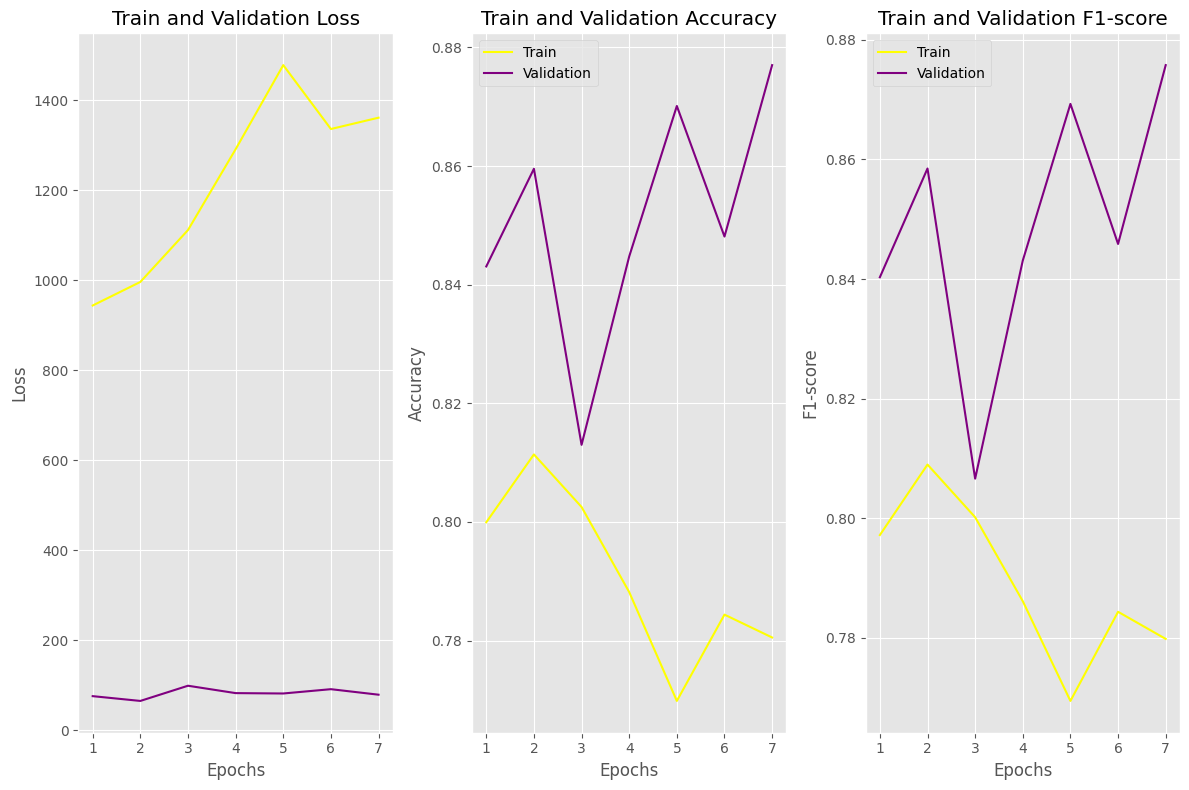

In [46]:
import matplotlib.pyplot as plt

# Retrieve the number of epochs
epochs = range(1, n_epochs + 1)

# Extract metrics from recorded lists
train_losses = [train_metrics['loss'] for train_metrics in train_metrics_list]
val_losses = [val_metrics['loss'] for val_metrics in val_metrics_list]
train_accs = [train_metrics['accuracy'] for train_metrics in train_metrics_list]
val_accs = [val_metrics['accuracy'] for val_metrics in val_metrics_list]
train_f1 = [train_metrics['f1_score'] for train_metrics in train_metrics_list]
val_f1 = [val_metrics['f1_score'] for val_metrics in val_metrics_list]

# Colors for the plots
train_color = 'yellow'
val_color = 'purple'

# Plotting the training and validation loss
plt.figure(figsize=(12, 8))
plt.subplot(1, 3, 1)
plt.plot(epochs, train_losses, color=train_color, label='Train')
plt.plot(epochs, val_losses, color=val_color, label='Validation')
plt.title('Train and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')


# Plotting the training and validation accuracy
plt.subplot(1, 3, 2)
plt.plot(epochs, train_accs, color=train_color, label='Train')
plt.plot(epochs, val_accs, color=val_color, label='Validation')
plt.title('Train and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting the training and validation F1-score
plt.subplot(1, 3, 3)
plt.plot(epochs, train_f1, color=train_color, label='Train')
plt.plot(epochs, val_f1, color=val_color, label='Validation')
plt.title('Train and Validation F1-score')
plt.xlabel('Epochs')
plt.ylabel('F1-score')
plt.legend()

plt.tight_layout()
plt.show()

# Learning Rate Plot
plt.figure(figsize=(15, 10))
plt.plot(epochs, [lr(epoch) for epoch in epochs], marker='o', color='green')  # Added green color for learning rate plot
plt.title('Learning Rate Schedule')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.show()


### Test Model (3 Points)

In [47]:
############################################################
##                  Test your best model                  ##
##          Report loss, accuracy and f1 metrics          ##
##      Also plot the confusion matrix for test data      ##
#######################[Your Code]##########################

test_sampler = RandomSampler(batch_size, (test_X, test_y), 'test')
test_loss = 0.0
test_conf_matrix = np.zeros((10, 10), dtype=int)
for x_batch, y_batch in val_sampler:

    predictions = best_model._forward(x_batch, mode='test')
    test_loss += ce._forward(predictions, y_batch)
    test_conf_matrix = update_confusion_matrix(test_conf_matrix, np.argmax(predictions, axis=1), y_batch)
test_loss /= len(test_sampler)
test_acc = np.trace(test_conf_matrix) / np.sum(test_conf_matrix)
test_f1 = f1_score(test_conf_matrix)
print(f"Loss for test is  : " +str(test_loss))
print("Accuracy for test is : "+ str(test_acc))
print("F1 score for test is: " + str(test_f1))

Loss for test is  : 0.5075368104921678
Accuracy for test is : 0.8771841397849462
F1 score for test is: 0.8757792701691555


In [48]:
from sklearn.metrics import ConfusionMatrixDisplay

# Assuming test_conf_matrix is correctly initialized and populated
disp = ConfusionMatrixDisplay(confusion_matrix=test_conf_matrix,
                              display_labels=[0,1,2,3,4,5,6,7,8,9])

# Increase the figure size for better readability
plt.figure(figsize=(10, 8))  # Adjusted from (3, 2) to (10, 8) for better display
disp.plot(cmap='viridis')  # Optionally, you can set a color map
plt.title('Confusion Matrix')
plt.show()

<Figure size 1000x800 with 0 Axes>